In [1]:
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
from bw_net_maml import BWNet_MAML
import torch
from thop import profile
from thop import clever_format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BWNet_MAML(embed_size=1).to(device)
# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(model, inputs=(x,))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")

## Train

Using cuda device
Epoch 1/100


Validation: 100%|██████████| 26/26 [01:44<00:00,  4.03s/it]


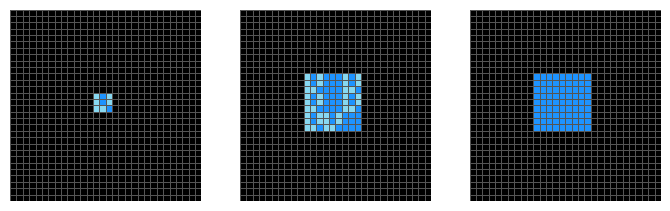

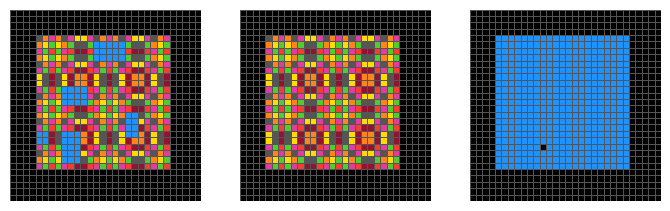

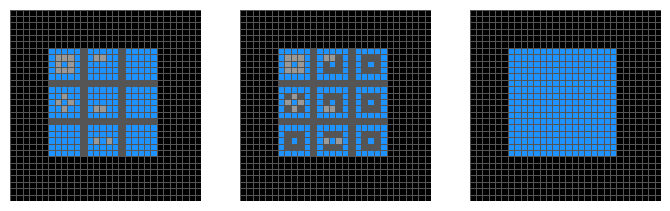

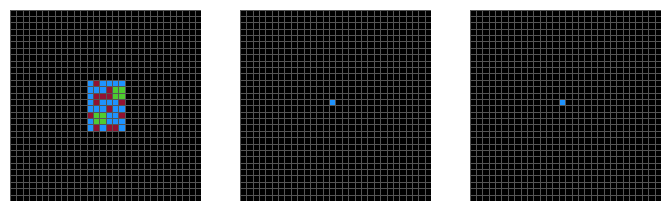

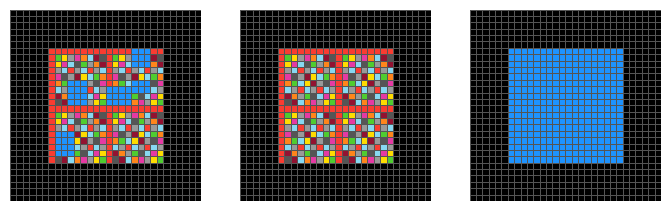

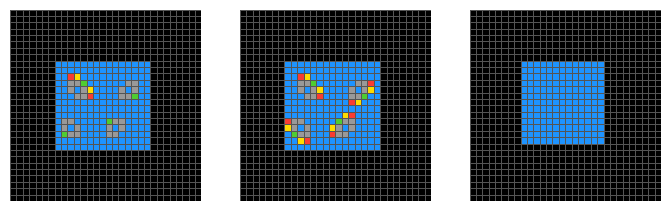

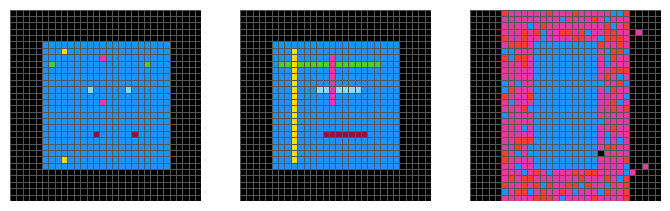

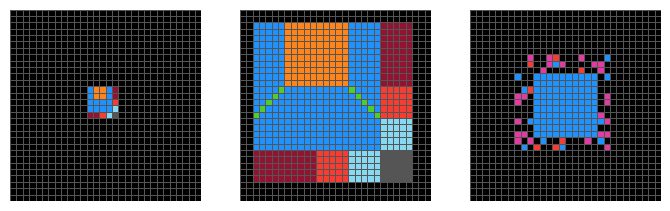

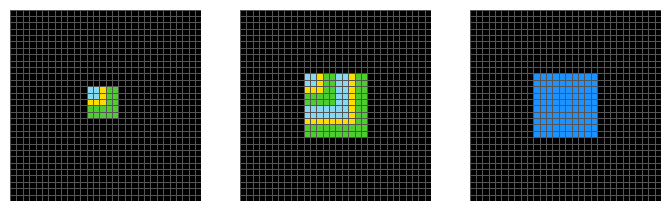

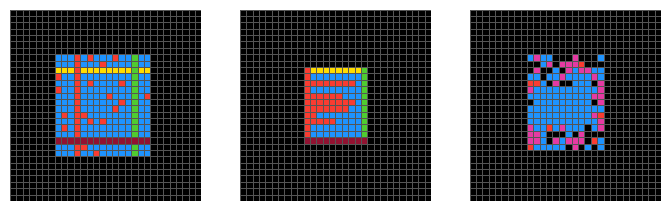

Epoch 1/100, Loss: 8.80021196384399, Accuracy: 38.09464991530209%
Epoch 2/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.06s/it]


Epoch 2/100, Loss: 8.716237109530152, Accuracy: 37.82114624505929%
Epoch 3/100


Validation: 100%|██████████| 26/26 [01:46<00:00,  4.09s/it]


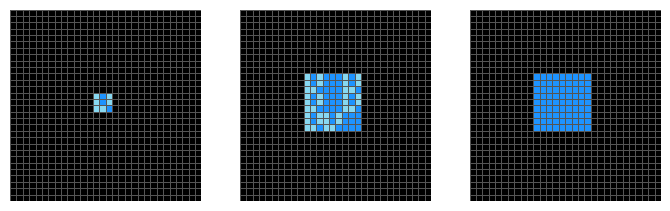

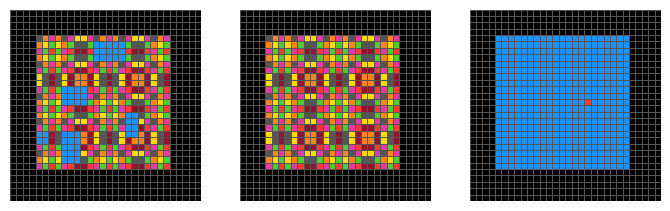

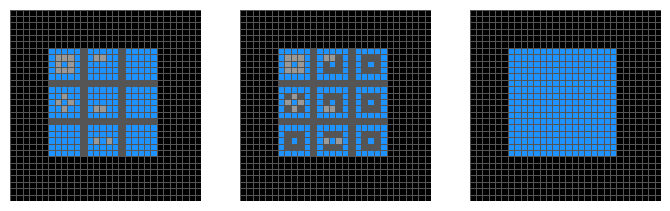

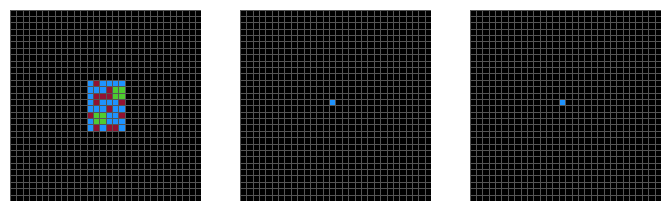

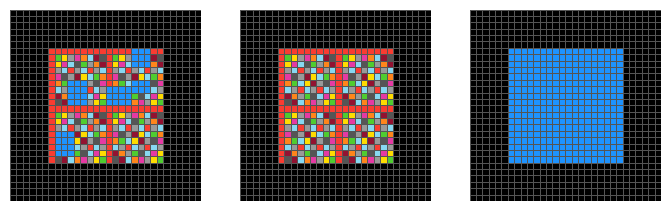

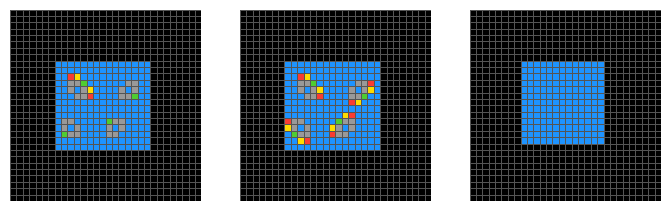

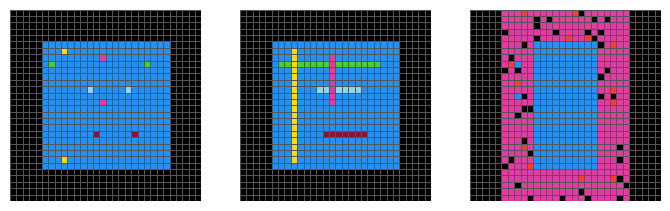

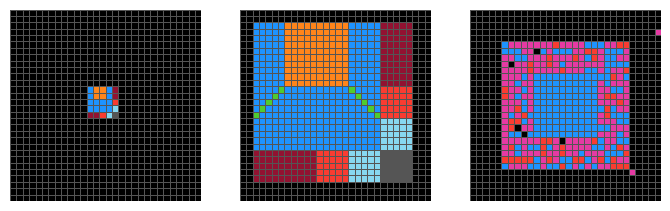

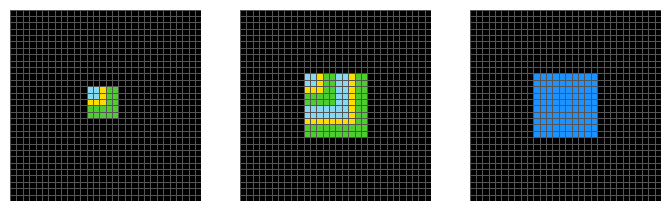

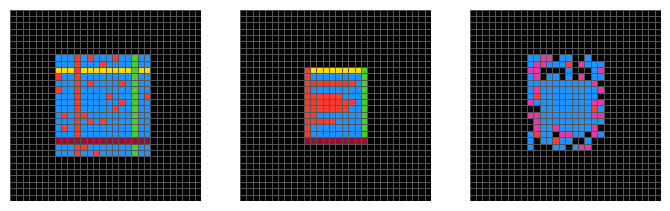

Epoch 3/100, Loss: 9.028746835279145, Accuracy: 38.447557876905705%
Epoch 4/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.04s/it]


Epoch 4/100, Loss: 8.801671468641567, Accuracy: 38.45814511575381%
Epoch 5/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.06s/it]


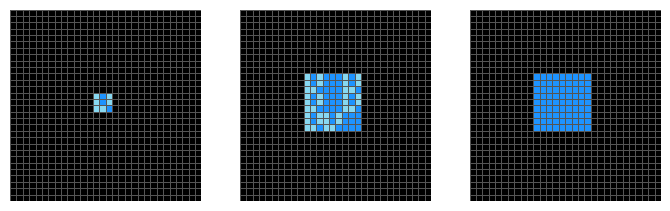

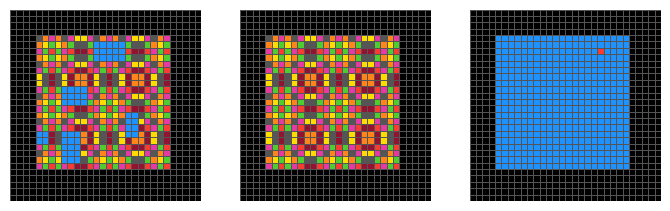

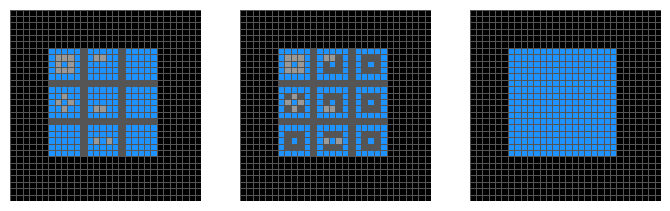

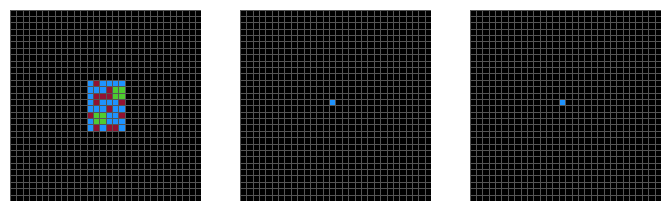

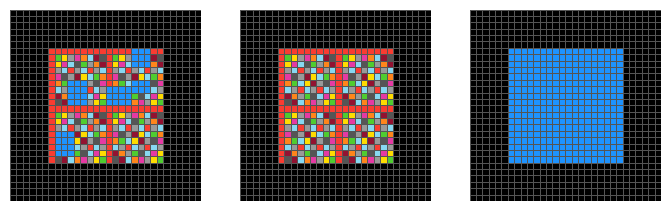

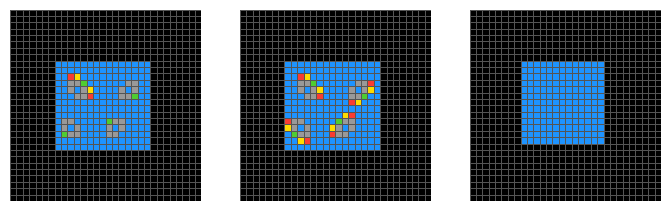

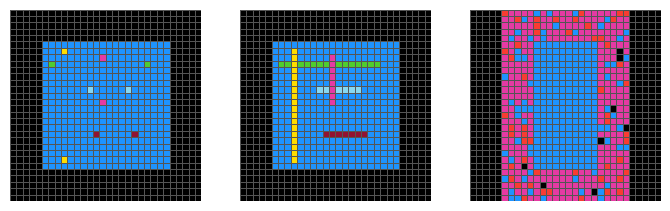

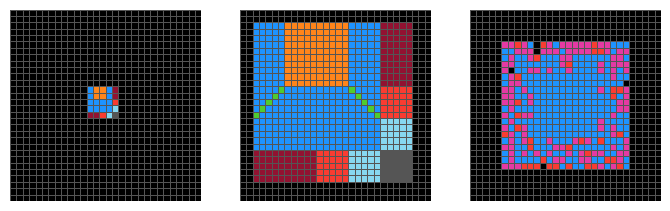

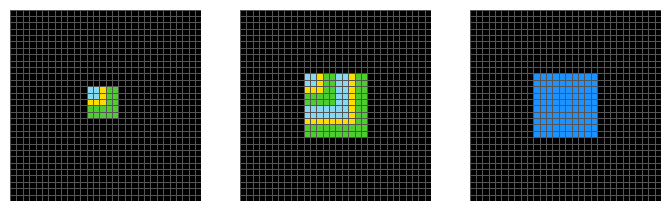

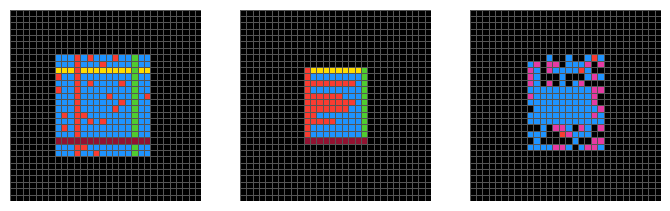

Epoch 5/100, Loss: 8.855442563943893, Accuracy: 38.461674195369845%
Epoch 6/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.04s/it]


Epoch 6/100, Loss: 8.82238740653841, Accuracy: 38.23934217955957%
Epoch 7/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.05s/it]


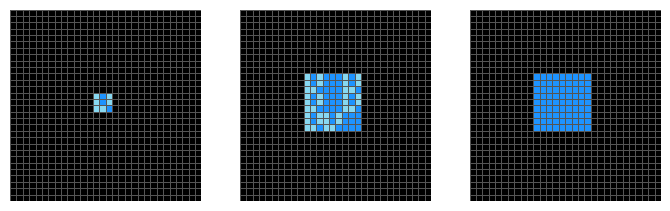

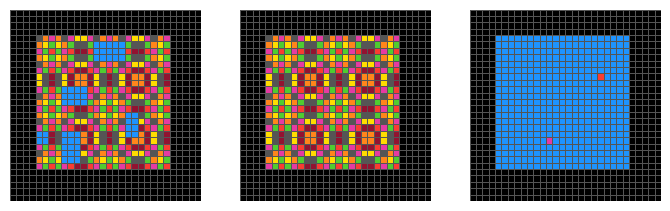

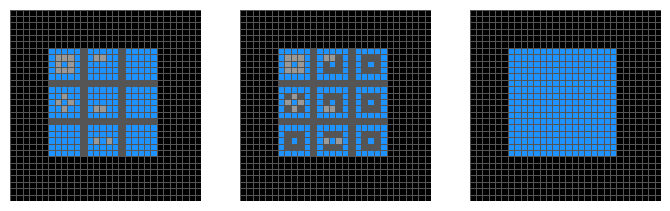

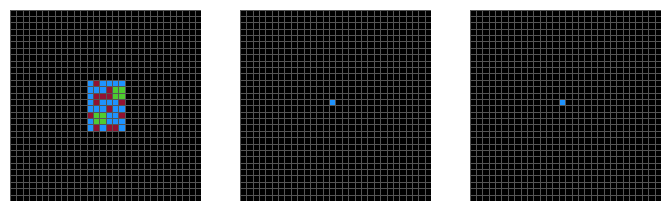

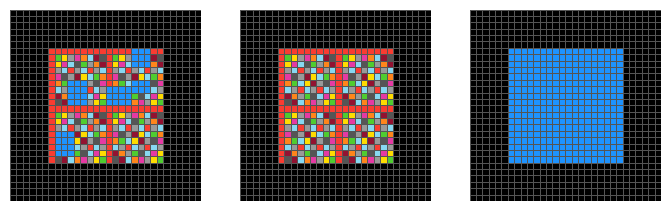

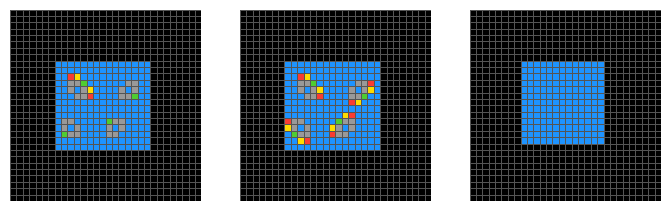

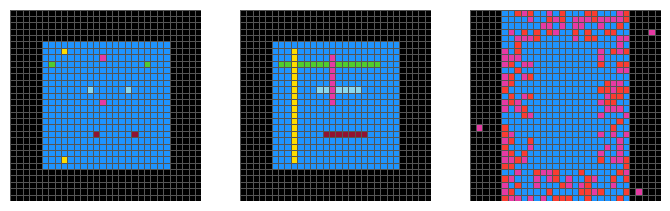

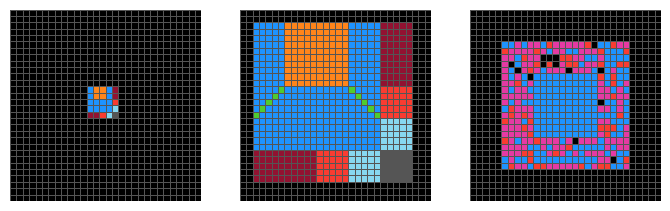

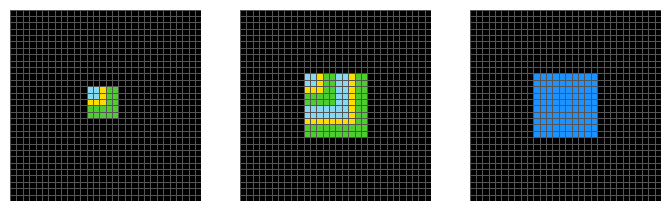

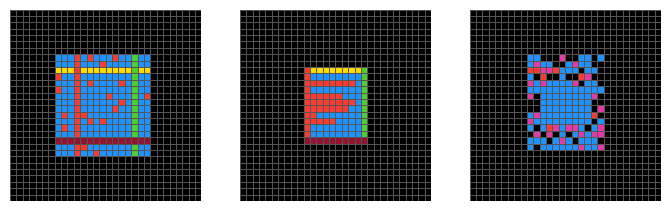

Epoch 7/100, Loss: 8.799162035550376, Accuracy: 38.3593308865048%
Epoch 8/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.05s/it]


Epoch 8/100, Loss: 9.077688635084415, Accuracy: 38.1934641445511%
Epoch 9/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.05s/it]


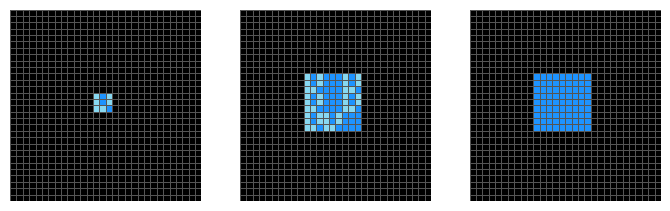

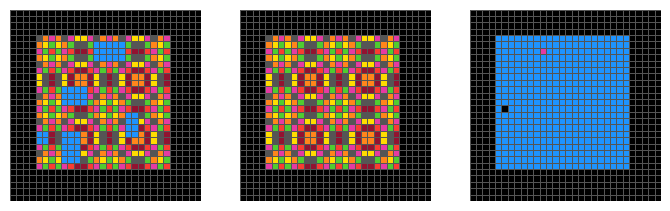

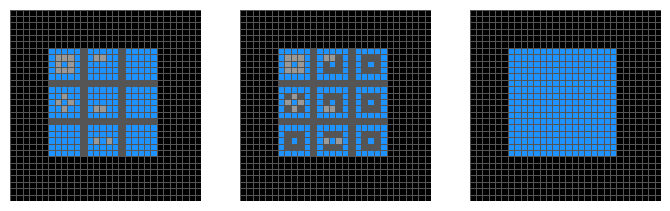

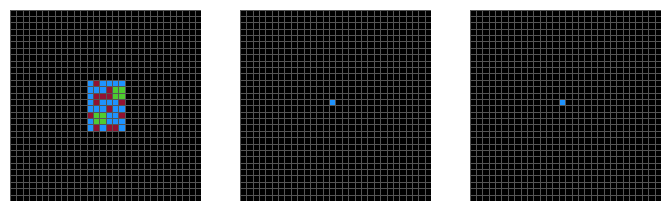

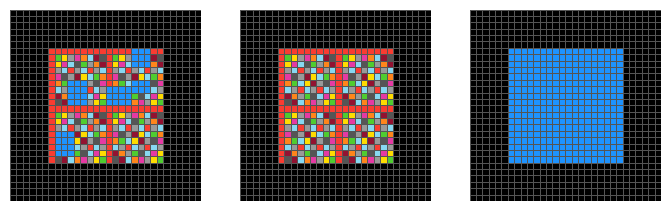

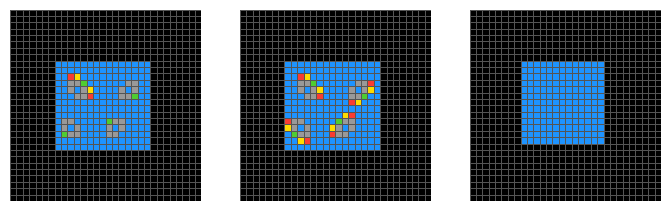

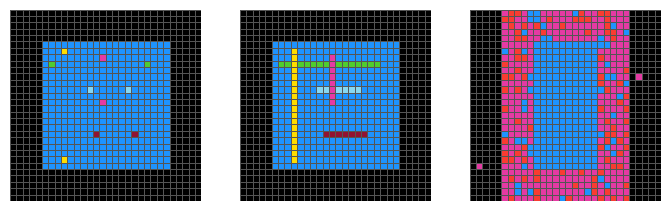

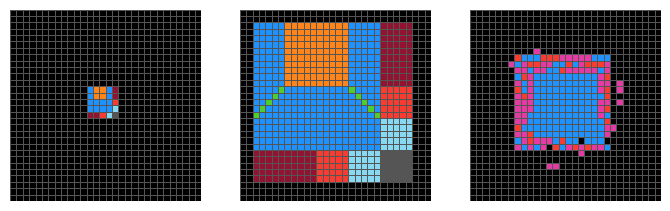

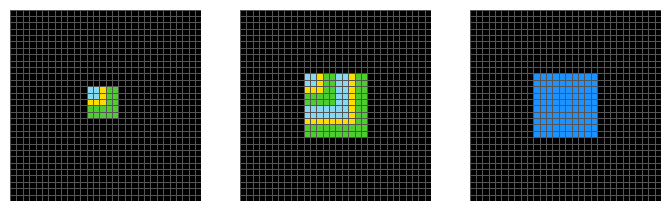

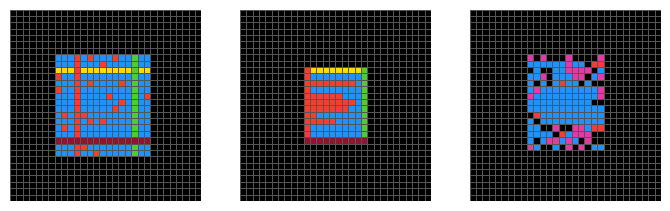

Epoch 9/100, Loss: 8.695003165100603, Accuracy: 38.216403162055336%
Epoch 10/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.06s/it]


Epoch 10/100, Loss: 8.554684956962683, Accuracy: 38.235813099943535%
Epoch 11/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.06s/it]


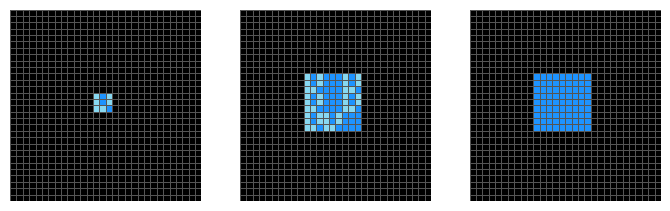

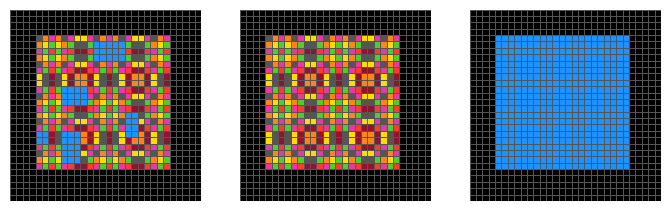

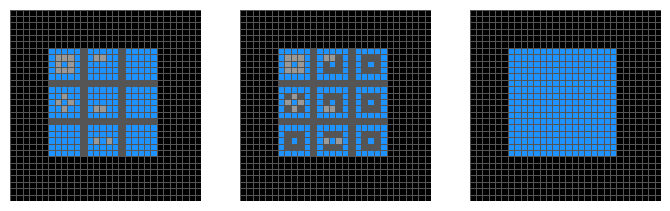

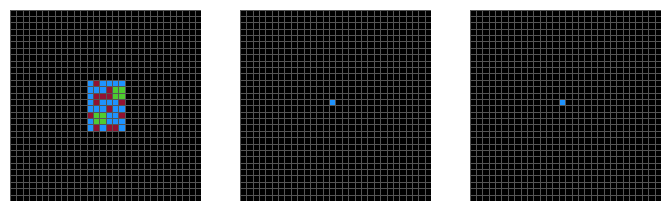

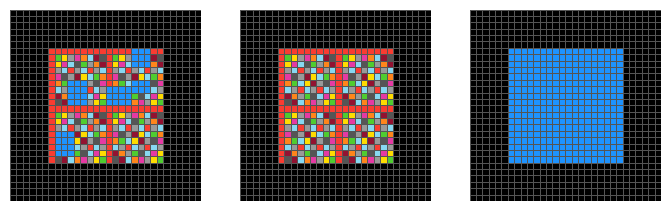

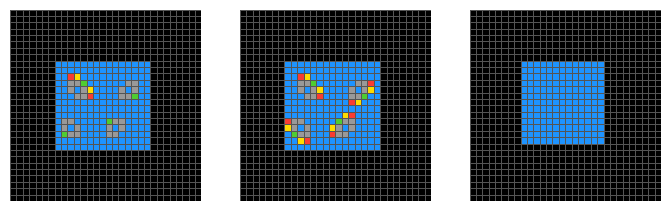

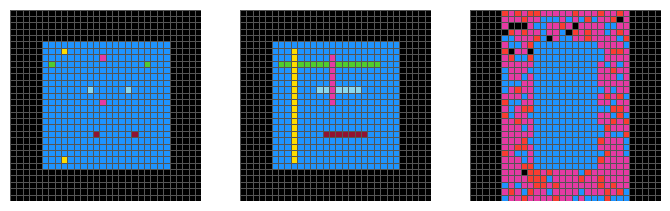

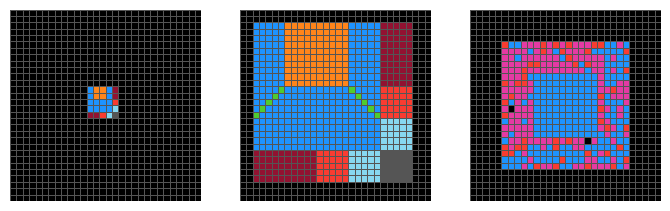

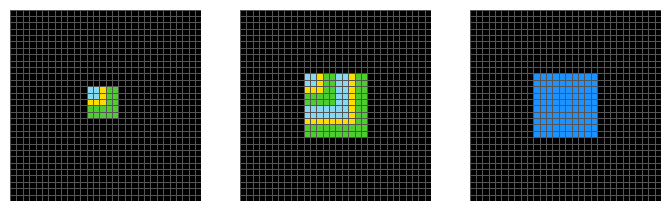

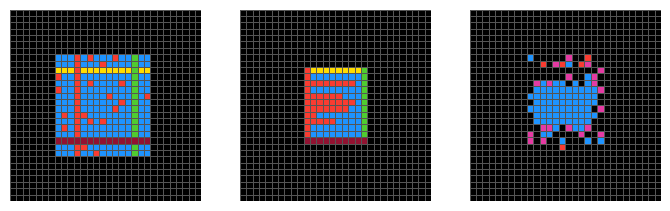

Epoch 11/100, Loss: 8.806160426361673, Accuracy: 38.648715415019765%
Epoch 12/100


Validation: 100%|██████████| 26/26 [01:46<00:00,  4.10s/it]


Epoch 12/100, Loss: 8.722802910144626, Accuracy: 38.703416149068325%
Epoch 13/100


Validation: 100%|██████████| 26/26 [01:46<00:00,  4.08s/it]


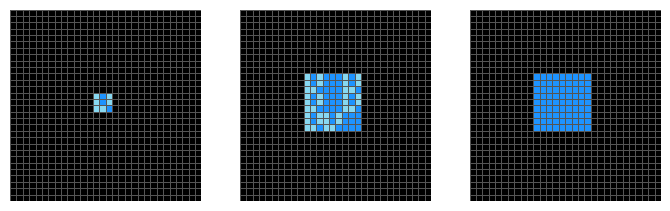

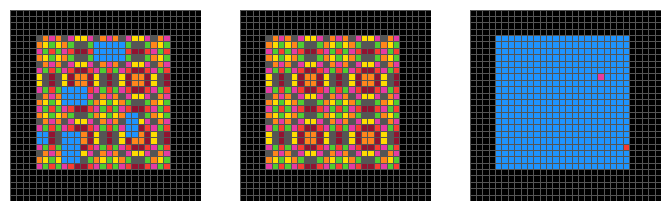

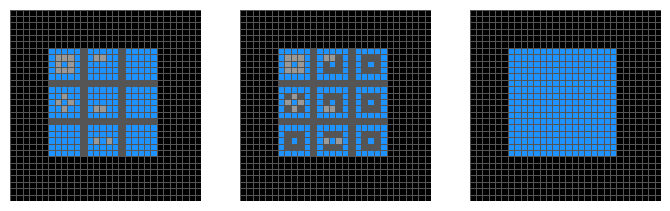

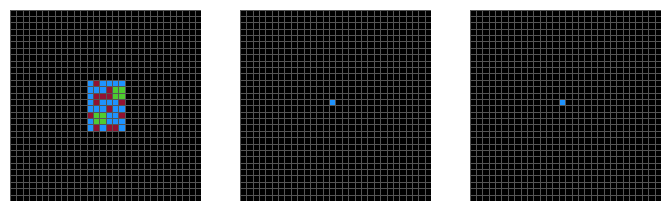

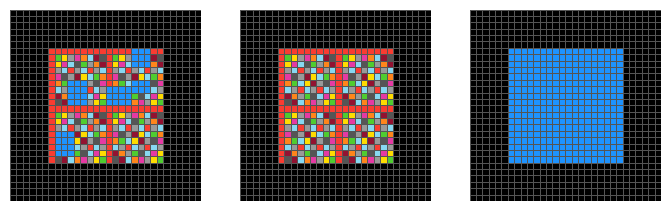

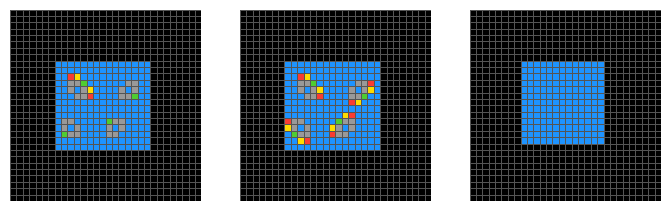

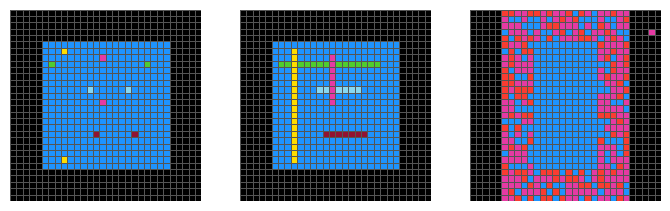

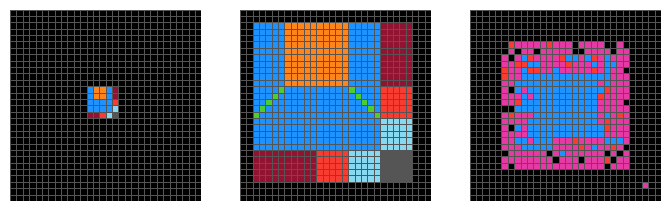

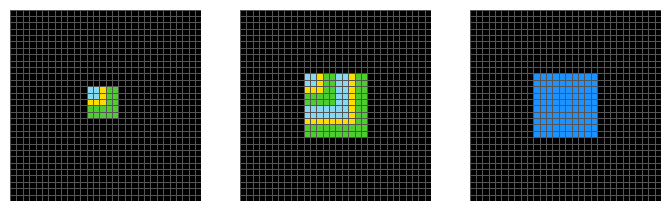

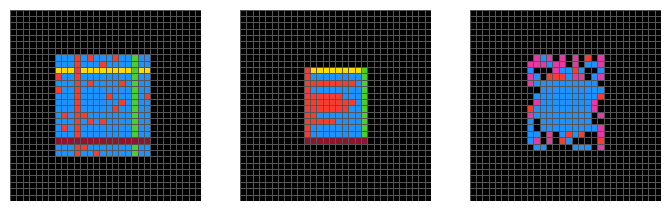

Epoch 13/100, Loss: 8.663589413225383, Accuracy: 38.42461885940147%
Epoch 14/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.08s/it]


Epoch 14/100, Loss: 8.623872947369035, Accuracy: 38.02936194240542%
Epoch 15/100


Validation: 100%|██████████| 26/26 [01:45<00:00,  4.07s/it]


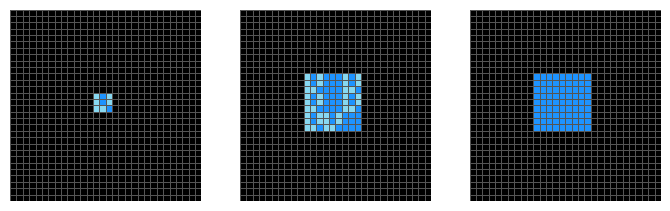

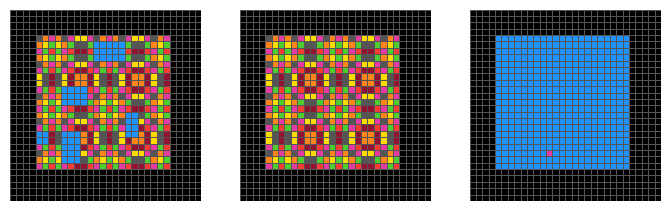

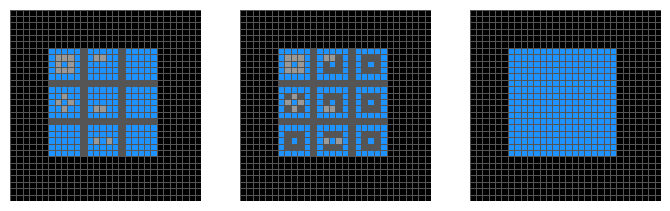

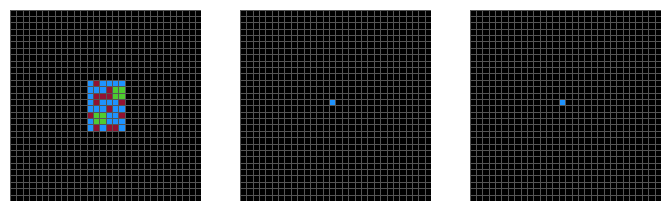

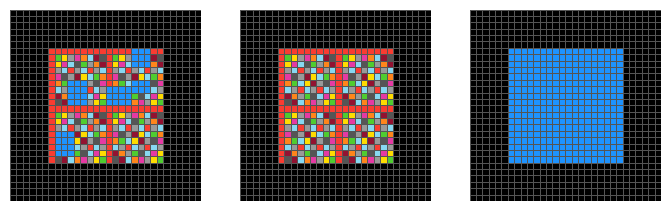

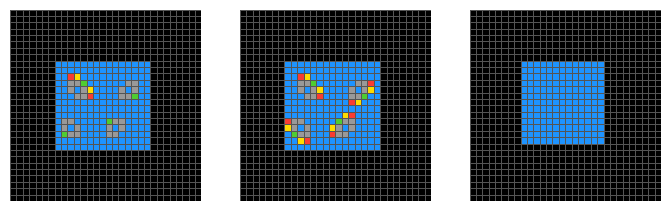

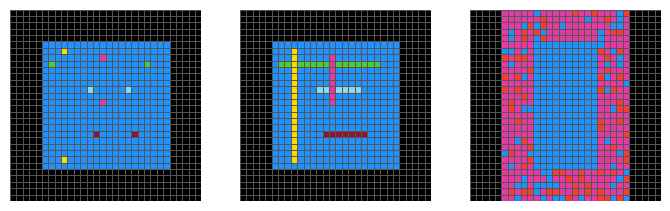

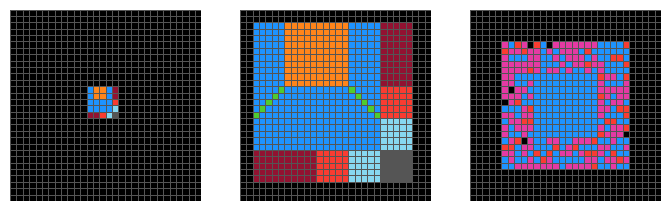

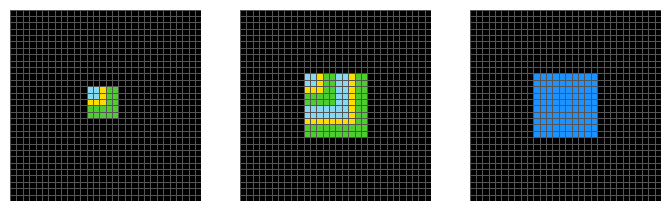

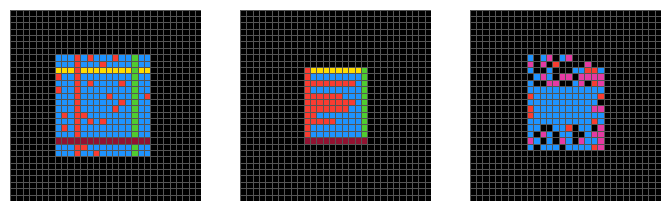

Epoch 15/100, Loss: 8.756323439840811, Accuracy: 37.849378881987576%
Epoch 16/100


Validation:  58%|█████▊    | 15/26 [01:02<00:46,  4.22s/it]

In [1]:
from bw_net_maml import BWNet_MAML
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc
import random
import random
import numpy as np
import torch

# Fix random seeds for reproducibility
def fix_random_seeds(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_random_seeds(77)

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')


# 총 클래스의 수
num_classes = 11

# 0번과 1번 클래스에 부여할 가중치 (10% 이하로 설정)
weight_0 = 0.04
weight_1 = 0.05

# 나머지 9개 클래스에 공평하게 가중치 부여
remaining_weight = 1.0 - (weight_0 + weight_1)
weight_other = remaining_weight / (num_classes - 2)

# 가중치 리스트 생성
class_weights = [weight_0, weight_1] + [weight_other] * (num_classes - 2)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y, weight=class_weights_tensor)
    # ce = F.cross_entropy(y_pred, y)
    return ce

def remapping_output(tensor):
    # 범위별 매핑 딕셔너리
    remapping = {
        (1, 10): -1,
        (11, 20): -2,
        (21, 30): -3,
        (31, 40): -4,
        (41, 50): -5,
        (51, 60): -6,
        (61, 70): -7,
        (71, 80): -8,
        (81, 90): -9,
        (91, 100): -10
    }
    
    temp_tensor = tensor.clone()

    # 각 범위에 대해 매핑 수행
    for value_range, new_value in remapping.items():
        mask = (temp_tensor >= value_range[0]) & (temp_tensor <= value_range[1])
        temp_tensor[mask] = new_value  # 임시로 기존 값에 음수를 취해 중복을 피함
    for value_range, new_value in remapping.items():
        temp_tensor[temp_tensor == new_value] = -1*new_value  # 음수로 변환된 값을 다시 양수로 변환

    return temp_tensor


colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        example_output = remapping_output(example_output)
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()


train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 100,
    'task_numbers': 16, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 5, #equal to inner model batch size
    'inner_lr': 0.001,
    'outer_lr': 0.001,
    'embed_size': 1,
    
}


train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

outer_model = BWNet_MAML(embed_size=kwargs['embed_size']).to(device)
outer_optimizer= optim.AdamW(outer_model.parameters(),lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    # total_samples = 0
    outer_model.train()

    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        
        # total_samples += input_tensor.shape[0]
        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(),lr=kwargs['inner_lr'])
            
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
        
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            ###
            task_output = remapping_output(output_tensor[task_number])
            task_loss = criterion(task_prediction, task_output)
            ###
            #task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()
        

    del inner_optimizer
    torch.cuda.empty_cache()
    gc.collect()
    
    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = []
    visualization_samples = []
    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_model.train()
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                            inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)

                task_output = remapping_output(task_output)

                task_loss = criterion(task_prediction, task_output)
                total_loss.append(task_loss.item())  # task_loss.item()을 리스트에 추가

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()
            
            if task_number == 0:
                if len(visualization_samples) < 10:  # 예를 들어 10개의 샘플만 저장
                            visualization_samples.append((
                                remapping_output(task_input.cpu()),
                                #remapping_output(task_output.cpu()),
                                #remapping_output(prediction_class.cpu())
                                task_output.cpu(),
                                prediction_class.cpu()
                            ))

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    if visualization_samples and epoch % 2 == 0:
        for vis_input, vis_output, vis_prediction in visualization_samples:
            show_grid_side_by_side(vis_input, vis_output, vis_prediction)

            

    # 손실 값들의 평균 계산
    mean_loss = sum(total_loss) / len(total_loss) if total_loss else 0
    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {mean_loss}, Accuracy: {accuracy}%')
    torch.cuda.empty_cache()

Using cuda device
Epoch 1/100


Validation: 100%|██████████| 13/13 [01:37<00:00,  7.48s/it]


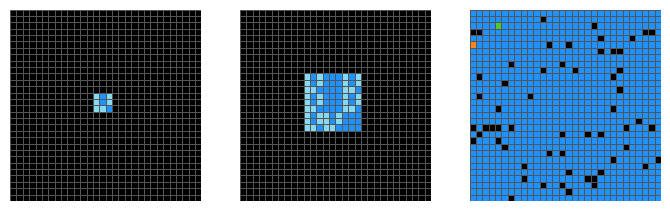

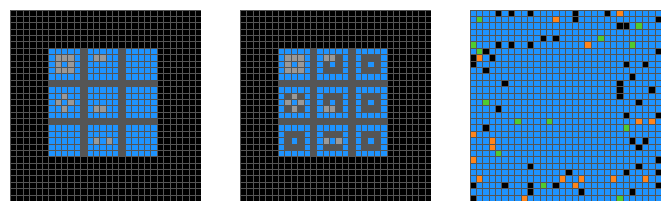

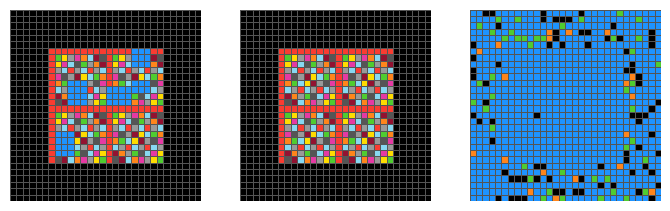

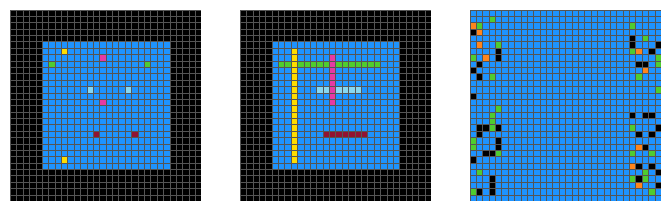

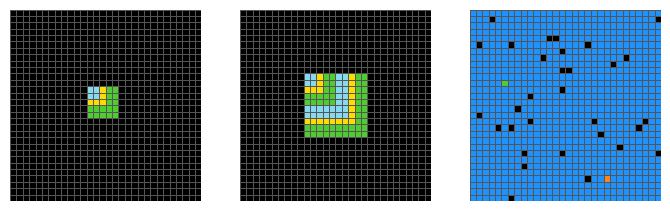

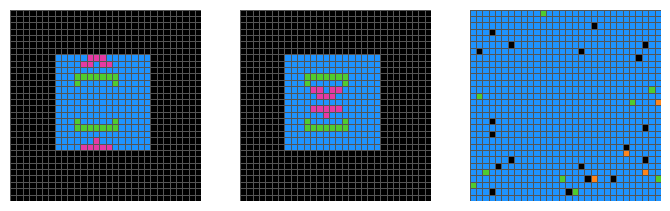

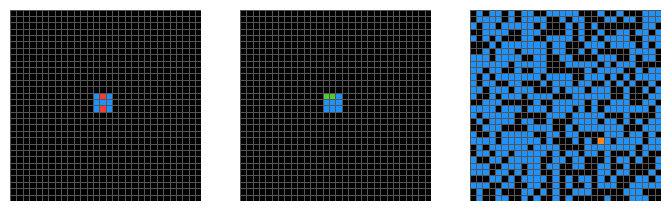

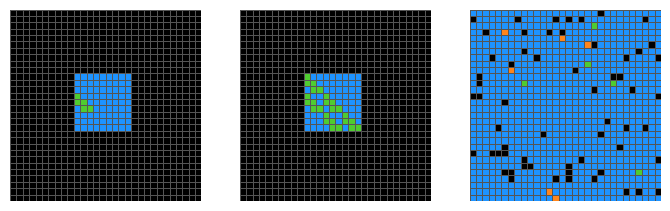

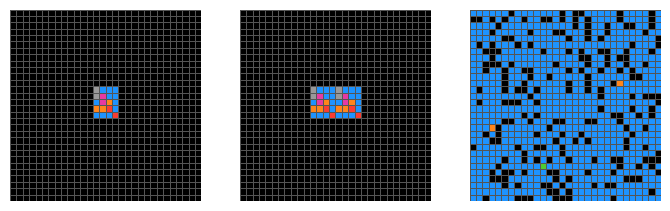

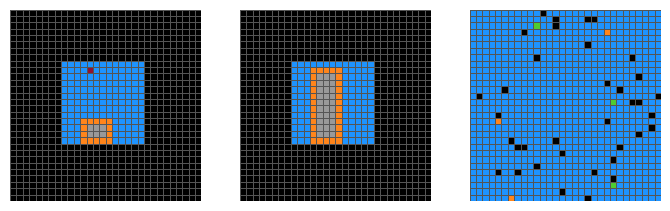

Epoch 1/100, Loss: 2.0113303910654325, Accuracy: 52.600931677018636%
Epoch 2/100


Validation: 100%|██████████| 13/13 [01:46<00:00,  8.21s/it]


Epoch 2/100, Loss: 2.0265374713792252, Accuracy: 52.27978543195935%
Epoch 3/100


Validation: 100%|██████████| 13/13 [01:46<00:00,  8.18s/it]


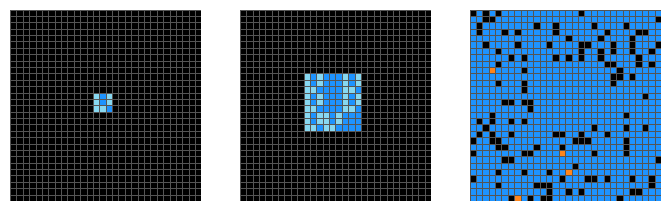

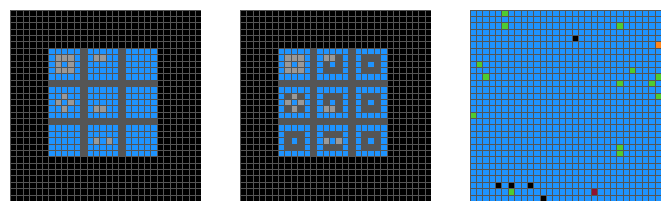

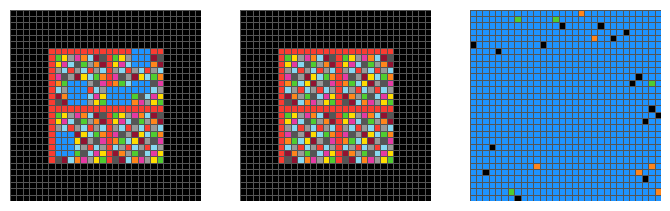

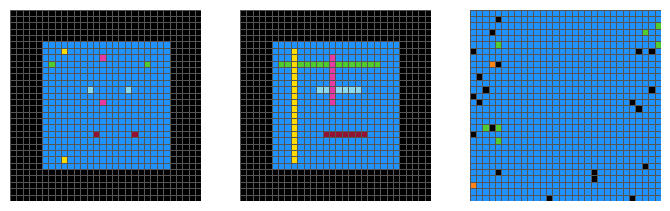

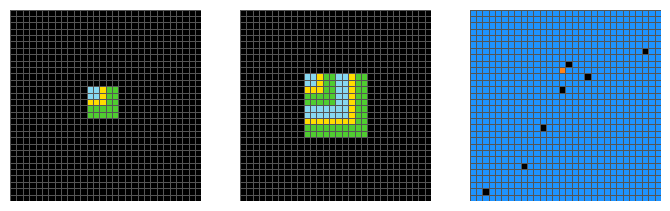

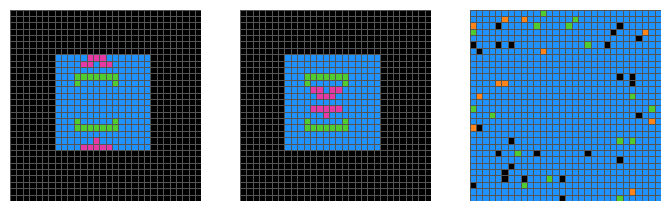

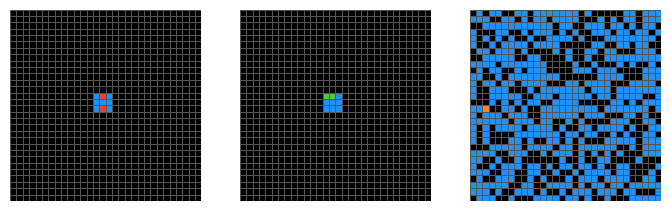

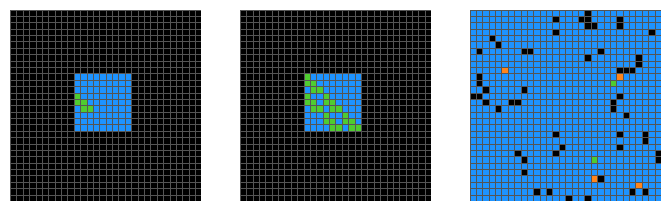

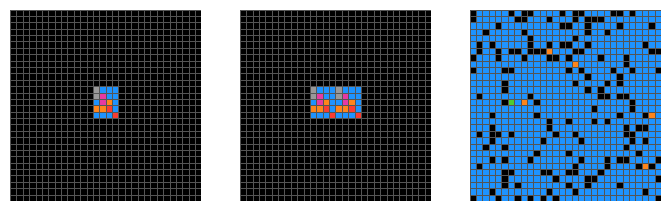

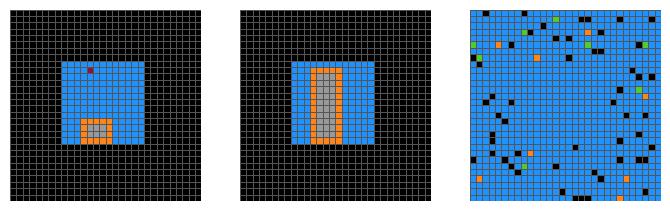

Epoch 3/100, Loss: 2.022692457987712, Accuracy: 52.4315358554489%
Epoch 4/100


Validation: 100%|██████████| 13/13 [01:45<00:00,  8.11s/it]


Epoch 4/100, Loss: 2.022276004919639, Accuracy: 52.609754376058724%
Epoch 5/100


Validation: 100%|██████████| 13/13 [01:47<00:00,  8.26s/it]


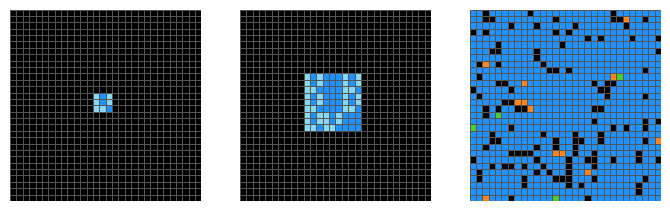

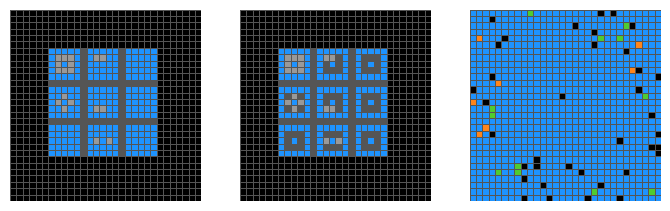

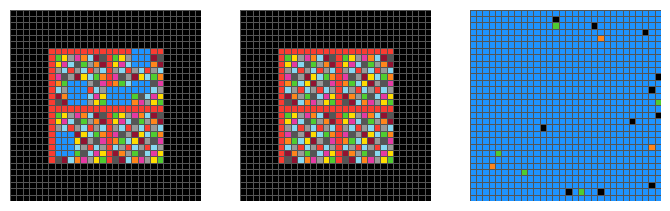

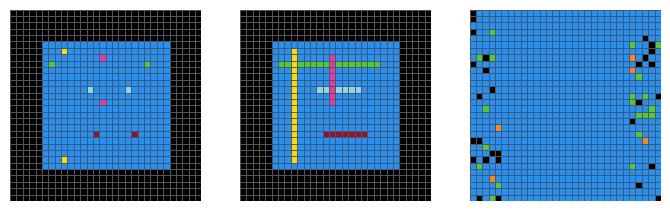

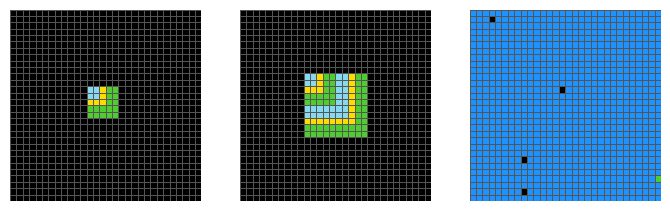

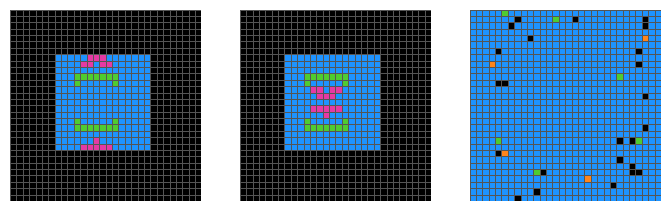

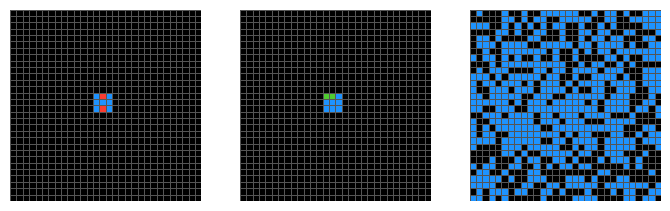

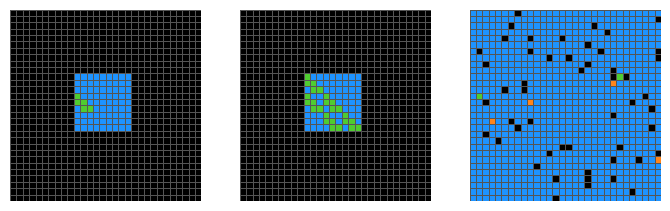

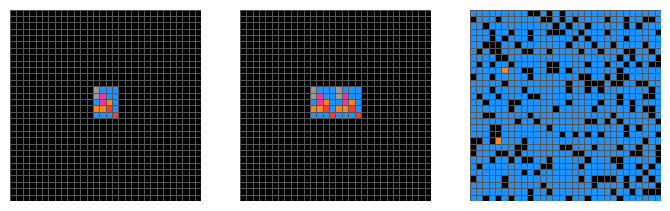

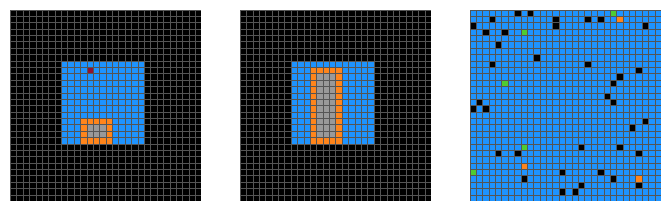

Epoch 5/100, Loss: 2.034228474761431, Accuracy: 52.364483342744215%
Epoch 6/100


Training:  54%|█████▍    | 7/13 [00:38<00:32,  5.45s/it]

In [1]:
from TheNew_bw import BWNet_MAML
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc
import random
import random
import numpy as np
import torch

# Fix random seeds for reproducibility
def fix_random_seeds(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_random_seeds(77)

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')


# 총 클래스의 수
num_classes = 11

# 0번과 1번 클래스에 부여할 가중치 (10% 이하로 설정)
weight_0 = 0.04
weight_1 = 0.05

# 나머지 9개 클래스에 공평하게 가중치 부여
remaining_weight = 1.0 - (weight_0 + weight_1)
weight_other = remaining_weight / (num_classes - 2)

# 가중치 리스트 생성
class_weights = [weight_0, weight_1] + [weight_other] * (num_classes - 2)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y, weight=class_weights_tensor)
    # ce = F.cross_entropy(y_pred, y)
    return ce

def remapping_output(tensor):
    # 범위별 매핑 딕셔너리
    remapping = {
        (1, 10): -1,
        (11, 20): -2,
        (21, 30): -3,
        (31, 40): -4,
        (41, 50): -5,
        (51, 60): -6,
        (61, 70): -7,
        (71, 80): -8,
        (81, 90): -9,
        (91, 100): -10
    }
    
    temp_tensor = tensor.clone()

    # 각 범위에 대해 매핑 수행
    for value_range, new_value in remapping.items():
        mask = (temp_tensor >= value_range[0]) & (temp_tensor <= value_range[1])
        temp_tensor[mask] = new_value  # 임시로 기존 값에 음수를 취해 중복을 피함
    for value_range, new_value in remapping.items():
        temp_tensor[temp_tensor == new_value] = -1*new_value  # 음수로 변환된 값을 다시 양수로 변환

    return temp_tensor


colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        example_output = remapping_output(example_output)
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()


train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 100,
    'task_numbers': 32, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 5, #equal to inner model batch size
    'inner_lr': 0.001,
    'outer_lr': 0.001,
    'embed_size': 4,
    
}


train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

outer_model = BWNet_MAML(embed_size=kwargs['embed_size']).to(device)
outer_optimizer= optim.AdamW(outer_model.parameters(),lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    # total_samples = 0
    outer_model.train()

    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        
        # total_samples += input_tensor.shape[0]
        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(),lr=kwargs['inner_lr'])
            
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
        
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            ###
            task_output = remapping_output(output_tensor[task_number])
            task_loss = criterion(task_prediction, task_output)
            ###
            #task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()
        

    del inner_optimizer
    torch.cuda.empty_cache()
    gc.collect()
    
    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = []
    visualization_samples = []
    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_model.train()
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                            inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)

                task_output = remapping_output(task_output)

                task_loss = criterion(task_prediction, task_output)
                total_loss.append(task_loss.item())  # task_loss.item()을 리스트에 추가

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()
            
            if task_number == 0:
                if len(visualization_samples) < 10:  # 예를 들어 10개의 샘플만 저장
                            visualization_samples.append((
                                remapping_output(task_input.cpu()),
                                #remapping_output(task_output.cpu()),
                                #remapping_output(prediction_class.cpu())
                                task_output.cpu(),
                                prediction_class.cpu()
                            ))

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    if visualization_samples and epoch % 2 == 0:
        for vis_input, vis_output, vis_prediction in visualization_samples:
            show_grid_side_by_side(vis_input, vis_output, vis_prediction)

            

    # 손실 값들의 평균 계산
    mean_loss = sum(total_loss) / len(total_loss) if total_loss else 0
    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {mean_loss}, Accuracy: {accuracy}%')
    torch.cuda.empty_cache()

In [ ]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

def criterion(y_pred,y):
    y = y.long()
    ce = F.cross_entropy(y_pred,y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"


kwargs = {
    'epochs': 5,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    
}
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

model = BWNet()
optimizer= optim.AdamW(model.parameters(),lr=kwargs['outer_lr'])

for data in train_loader:
      input_tensor, output_tensor, example_input, example_output = data
      print(f'Input: {input_tensor.shape}')
      for task_number in range(input_tensor.shape[0]):
        task_input = input_tensor[task_number]
        task_output = output_tensor[task_number]
        ex_input = example_input[task_number]
        ex_output = example_output[task_number]
        print(f'Task {task_number+1}/{kwargs["task_numbers"]}')
        print(f'Input: {task_input.shape}')
        print(f'Output: {task_output.shape}')
        print(f'Example Input: {ex_input.shape}')
        print(f'Example Output: {ex_output.shape}')
        print('---------------------------------')


Input: torch.Size([10, 1, 1, 30, 30])
Task 1/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 2/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 3/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 4/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 5/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 3

In [ ]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

def criterion(y_pred,y):
    y = y.long()
    ce = F.cross_entropy(y_pred,y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"


kwargs = {
    'epochs': 5,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    
}
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

model = BWNet()
optimizer= optim.AdamW(model.parameters(),lr=kwargs['outer_lr'])

for data in eval_loader:
      input_tensor, output_tensor, example_input, example_output = data
      print(f'Input: {input_tensor.shape}')
      for task_number in range(input_tensor.shape[0]):
        task_input = input_tensor[task_number]
        task_output = output_tensor[task_number]
        ex_input = example_input[task_number]
        ex_output = example_output[task_number]
        print(f'Task {task_number+1}/{kwargs["task_numbers"]}')
        print(f'Input: {task_input.shape}')
        print(f'Output: {task_output.shape}')
        print(f'Example Input: {ex_input.shape}')
        print(f'Example Output: {ex_output.shape}')
        print('---------------------------------')


Input: torch.Size([10, 1, 1, 30, 30])
Task 1/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 2/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 3/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 4/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 5/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 3